# Distribution Dimensionality
PyMC には、分布の次元を指定するためのさまざまな方法が用意されています。 このドキュメントでは概要を説明し、ユーザーへのヒントをいくつか提供します。

## Glossary
このドキュメントでは、次元の概念を指すために次元という用語を使用します。 以下の各用語には、PyMC における特定の意味論的および計算上の定義があります。 ここではそれらを共有しますが、以下の例で見るとさらに意味が分かります。

* Support dimensions → ディストリビューションの中核となる次元
* Batch dimensions → ディストリビューションのサポート次元を超える追加の次元
* Implicit dimensions → 分布パラメータの値または形状から導かれる次元
* Explicit dimensions → 次の引数のいずれかによって明示的に定義されるディメンション:
    * Shape → ディストリビューションからの描画数
    * Dims → 次元名の配列
* Coords → 寸法名を座標値にマッピングする辞書

In [45]:
from functools import partial

import pymc as pm
import numpy as np
import pytensor.tensor as pt

## Univariate distribution example
最も単純なケースである単一の正規分布から始めることができます。 PyMC モデルの外側を指定するには ```.dist``` を使用します。

In [46]:
normal_dist = pm.Normal.dist()

次に、```draw()``` 関数を使用して、その分布からランダムに抽出することができます。

In [47]:
# Just patching the draw function for reproducibility
rng = np.random.default_rng(seed = sum(map(ord, "dimensionality")))
draw = partial(pm.draw, random_seed=rng)

In [48]:
normal_draw = draw(normal_dist)
normal_draw, normal_draw.ndim

(array(0.80189558), 0)

この場合、最終的には単一のスカラー値になります。 これは、取得できる最小のランダム描画は次元が 0 のスカラーであるため、正規分布にはスカラー サポート次元があることを意味します。 すべてのディストリビューションのサポート次元は、プロパティとしてハードコードされています。

In [49]:
normal_dist.owner.op.ndim_supp

0

### Explicit batch dimensions
複数の描画が必要な場合、同じ変数のコピーを複数作成し、それらをスタックするのが自然な傾向です。

In [50]:
normal_dists = pm.math.stack([pm.Normal.dist() for _ in range(3)])
draw(normal_dists)

array([ 0.83636296, -0.33327414,  0.9434115 ])

もっと簡単に言うと、shape 引数を使用して、同じディストリビューション ファミリから独立した描画のバッチを作成できます。

In [51]:
normal_dists = pm.Normal.dist(shape = (3,))
draw(normal_dists)

array([ 0.98810294, -0.07003785, -0.37962748])

In [52]:
normal_dists = pm.Normal.dist(shape = (4, 3))
draw(normal_dists)

array([[ 7.99932116e-04, -1.94407945e+00,  3.90451962e-01],
       [ 1.10657367e+00,  6.49042149e-01, -1.09450185e+00],
       [-2.96226305e-01,  1.41884595e+00, -1.31589441e+00],
       [ 1.53109449e+00, -7.73771737e-01,  2.37418367e+00]])

これはより簡潔であるだけでなく、より効率的なベクトル化コードを生成します。 個別のディストリビューション ファミリからの描画を組み合わせる必要がない限り、PyMC ではスタック アプローチを使用することはほとんどありません。

### Implicit batch dimensions
形状を指定せずに、より高い次元のパラメーターを渡すことで描画のバッチを作成することもできます。

In [53]:
normal_dists = pm.Normal.dist(mu = np.array([0, 0, 0]), sigma = np.array([1, 1, 1]))
draw(normal_dists)

array([ 0.81833093, -0.2891973 ,  1.2399946 ])

これは、明示的な形状を使用した前の例と同等であり、ここで明示的に渡すこともできます。 そうしなかったため、これらのバッチ ディメンションを暗黙的であると呼びます。

これが非常に役立つのは、バッチのディメンション間でパラメータを変化させたい場合です。

In [54]:
draw(pm.Normal.dist(mu = [1, 10, 100], sigma = 0.0001))

array([  0.99989975,  10.00009874, 100.00004215])

パラメータが同じ形状を持たない場合、NumPy の動作と同様の方法でブロードキャストされます。 この場合、```sigma``` は ```mu``` の形状に合わせてブロードキャストされました。

In [55]:
np.broadcast_arrays([1, 10, 100], 0.0001)

[array([  1,  10, 100]), array([0.0001, 0.0001, 0.0001])]

NumPy [ブロードキャスト](https://numpy.org/doc/stable/user/basics.broadcasting.html#basics-broadcasting) がどのように機能するかを理解することが重要です。 無効なことを行うと、次のようなエラーが発生しやすくなります。

In [56]:
try:
    # shapes of (3,) and (2,) can't be broadcasted together
    draw(pm.Normal.dist(mu=[1, 10, 100], sigma=[0.1, 0.1]))
except ValueError as error:
    print(error)

Could not broadcast dimensions. Incompatible shapes were [(ScalarConstant(ScalarType(int64), data=3),), (ScalarConstant(ScalarType(int64), data=2),)].


### Combining implicit and explicit batch dimensions
明示的な形状ディメンションと暗黙的なバッチディメンションを組み合わせることができます。 上で述べたように、それらは同じ情報を提供できます。

In [57]:
normal_dists = pm.Normal.dist(mu = np.array([0, 1, 2]), sigma = 1, shape = (3,))
draw(normal_dists)

array([ 0.06413633,  1.29893485, -0.48072495])

ただし、形状を使用して、暗黙的なバッチ次元を超えて拡張することもできます。

In [58]:
normal_dists = pm.Normal.dist(mu = np.array([0, 1, 2]), sigma = 1, shape = (4, 3))
draw(normal_dists)

array([[-0.49526775, -0.94608062,  1.66397913],
       [ 0.703617  ,  0.66713031,  0.80725231],
       [ 0.19219926,  1.62987906,  2.30590873],
       [ 1.83763939, -0.19878079,  1.46751553]])

ブロードキャスト ルールにより、明示的なバッチ ディメンションは常に暗黙的なディメンションの「左側に配置」する必要があることに注意してください。 したがって、前の例では、```shape = (4, 3)``` は有効ですが、```shape = (3, 4)``` は有効ではありません。 最初のシェイプにはブロードキャストされましたが、2 番目のシェイプにはブロードキャストされませんでした。

In [59]:
try:
    draw(pm.Normal.dist(mu = np.array([0, 1, 2]), sigma = 1, shape = (3, 4)))
except ValueError as error:
    print(error)

shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3, 4) and arg 1 with shape (3,).
Apply node that caused the error: normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AC4F702420>), [3 4], 11, [0 1 2], 1)
Toposort index: 0
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(2,)), TensorType(int64, shape=()), TensorType(int32, shape=(3,)), TensorType(int8, shape=())]
Inputs shapes: ['No shapes', (2,), (), (3,), ()]
Inputs strides: ['No strides', (8,), (), (4,), ()]
Inputs values: [Generator(PCG64) at 0x2AC4F702420, array([3, 4], dtype=int64), array(11, dtype=int64), array([0, 1, 2]), array(1, dtype=int8)]
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be

Normal 変数に ```shape = (3, 4) ``` を持たせる必要がある場合は、定義後に転置できます。

In [60]:
transposed_normals = pm.Normal.dist(mu = np.array([0, 1, 2]), sigma = 1, shape = (4, 3)).T
draw(transposed_normals)

array([[ 1.36252056,  0.90337366, -1.83306938, -1.04031058],
       [ 0.09757005, -0.03093604,  3.29729122, -0.86869013],
       [ 3.51136436, -0.33437459,  1.93223367,  3.71535763]])

````
```Tip
ディストリビューションの定義で設定されたディメンションと、転置、インデックス付け、ブロードキャストなどの下流の操作で設定されたディメンションを混同しないことが重要です。 PyMC でサンプリングする場合 (フォワード サンプリングまたは MCMC によるものであっても)、ランダムな抽出は常に分布形状から発生します。 次の例では、2 つの変数の最終的な形状が同じであるにもかかわらず、実際には異なる数の「ランダム」描画が行われたことに注目してください。
```
````

In [61]:
vector_normals = pm.Normal.dist(shape = (3,))
broadcasted_normal = pt.broadcast_to(pm.Normal.dist(), (3,))

In [62]:
draw(vector_normals), draw(broadcasted_normal)

(array([-0.73397401,  2.54543846, -1.14705529]),
 array([-0.45755879, -0.45755879, -0.45755879]))

## Multivariate distribution example
定義上、一部の分布は評価時に複数の値を返します。 これは、値のベクトル、行列、または任意の多次元テンソルである可能性があります。 例としては、常にベクトル (1 次元の配列) を返す多変量正規関数があります。

In [63]:
mvnormal_dist = pm.MvNormal.dist(mu = np.ones(3), cov = np.eye(3))
mvnormal_draw = draw(mvnormal_dist)
mvnormal_draw, mvnormal_draw.ndim

(array([1.29866199, 1.01091254, 0.08414986]), 1)

他のディストリビューションと同様に、サポート次元は固定プロパティとして指定されます。

In [64]:
mvnormal_dist.owner.op.ndim_supp

1

他のディストリビューションと同様に、サポート次元は固定プロパティとして指定されます。

In [65]:
mvnormal_dist.owner.op.ndim_supp

1

単一次元の MvNormal を指定した場合でも、ベクトルが返されます。

In [66]:
smallest_mvnormal_dist = pm.MvNormal.dist(mu = [1], cov = [[1]])
smallest_mvnormal_draw = draw(smallest_mvnormal_dist)
smallest_mvnormal_draw, smallest_mvnormal_draw.ndim

(array([0.55390975]), 1)

### Implicit support dimensions
先ほど見た MvNormal の例では、サポート ディメンションは実際には暗黙的でした。 3 ドローまたは 1 ドローのベクトルが必要であるとはどこにも指定されていませんでした。 これは ```mu``` と ```cov``` の形状から推測されました。 そのため、これを暗黙的なサポート ディメンションと呼びます。 形状を使用することで、もう少し明示的にすることができます。

In [67]:
explicit_mvnormal = pm.MvNormal.dist(mu = np.ones(3), cov = np.eye(3), shape = (3,))
draw(explicit_mvnormal)

array([-0.68893796,  1.10911095, -0.30443374])

````
```Warning
ただし、この記述の時点では、形状はサポート寸法として単に無視されることに注意してください。 これは、予想される寸法にラベルを付けるための「タイプヒント」としてのみ機能します。
```
````

In [68]:
ignored_shape_mvnormal = pm.MvNormal.dist(mu = np.ones(3), cov = np.eye(3), shape = (4,))
draw(ignored_shape_mvnormal)

array([0.57262853, 0.34230354, 1.96818163])

### Explicit batch dimensions
単変量分布と同様に、明示的にバッチ化されたディメンションを追加できます。 これを説明するために別のベクトル分布、多項分布を使用します。 次のスニペットは、それぞれがサイズ 3 のベクトルである 5 つの独立した多項分布の行列を定義します。

In [69]:
draw(pm.Multinomial.dist(n=5, p=[0.1, 0.3, 0.6], shape=(5, 3)))

array([[0, 2, 3],
       [0, 2, 3],
       [1, 0, 4],
       [0, 1, 4],
       [0, 1, 4]], dtype=int64)

````
```Warning
繰り返しますが、形状はサポートの次元に影響を与えないことに注意してください。
```
````

In [70]:
draw(pm.Multinomial.dist(n = 5, p = [0.1, 0.3, 0.6], shape = (5, 4)))

array([[2, 0, 3],
       [1, 1, 3],
       [0, 2, 3],
       [0, 1, 4],
       [1, 0, 4]], dtype=int64)

同じ理由で、サポート ディメンションの「左側」に明示的にバッチ ディメンションを定義する必要があります。 以下は期待どおりに動作しません。

In [71]:
draw(pm.Multinomial.dist(n = 5, p = [0.1, 0.3, 0.6], shape = (3, 5)))

array([[0, 1, 4],
       [0, 0, 5],
       [3, 1, 1]], dtype=int64)

多項変数に ```shape = (3, 5)```` を持たせる必要がある場合は、定義後に転置できます。

In [72]:
transposed_multinomials = pm.Multinomial.dist(n = 5, p = [0.1, 0.3, 0.6], shape = (5, 3)).T
draw(transposed_multinomials)

array([[2, 1, 1, 0, 2],
       [0, 3, 1, 0, 1],
       [3, 1, 3, 5, 2]], dtype=int64)

### Implicit batch dimensions
単変量分布と同様に、バッチ化されたディメンションごとに異なるパラメーターを使用できます。

In [73]:
multinomial_dist = pm.Multinomial.dist(n = [5, 10], p = [0.1, 0.3, 0.6])
draw(multinomial_dist)

array([[0, 2, 3],
       [1, 4, 5]], dtype=int64)

これはより冗長なものと同等です

In [74]:
draw(pm.Multinomial.dist(n = [5, 10], p = [[0.1, 0.3, 0.6], [0.1, 0.3, 0.6]]))

array([[1, 2, 2],
       [0, 3, 7]], dtype=int64)

NumPy ブロードキャスト ルールに精通している場合は、PyMC がこれをどのように機能させるかに興味があるかもしれません。 ここでは単純なブロードキャストは機能しません

In [75]:
try:
    np.broadcast_arrays([5, 10], [0.1, 0.3, 0.6])
except ValueError as exc:
    print(exc)

shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (3,).


何が起こっているのかを理解するには、パラメーター コア ディメンションの概念を導入する必要があります。 分布のパラメータのコア次元は、分布を定義するためにパラメータに必要な次元の最小数です。 多項分布では、``n`` は少なくともスカラー整数でなければなりませんが、``p`` は少なくとも各カテゴリで結果が得られる確率を表すベクトルでなければなりません。 したがって、多項分布の場合、 ``n`` は 0 コア次元を持ち、 ``p`` は 1 コア次元を持ちます。

したがって、2 つの ``n`` のベクトルがある場合、実際には ``p`` のベクトルを 2 つのそのようなベクトルを含む行列にブロードキャストし、各 ``n`` をそれぞれのベクトルとペアにする必要があります。 ```p``` の行をブロードキャストしました。 これは ```np.vectorize``` とまったく同じように機能します。

In [76]:
def core_multinomial(n, p):
    print(">>", n, p)
    return draw(pm.Multinomial.dist(n, p))


vectorized_multinomial = np.vectorize(core_multinomial, signature = "(),(p)->(p)")
vectorized_multinomial([5, 10], [0.1, 0.3, 0.6])

>> 5 [0.1 0.3 0.6]
>> 10 [0.1 0.3 0.6]


array([[2, 2, 1],
       [1, 1, 8]], dtype=int64)

各分布パラメータのコア次元も、各分布のプロパティとしてハードコードされています。

In [77]:
multinomial_dist.owner.op.ndims_params

(0, 1)

暗黙的なバッチ ディメンションは引き続きブロードキャスト ルールを尊重する必要があります。 次の例は、```n``` のバッチ次元が ```shape = (2,)``` であり、```p``` のバッチ次元が ```shape = (3, )``` を一緒に放送することはできません。

In [78]:
try:
    draw(pm.Multinomial.dist(n=[5, 10], p=[[0.1, 0.3, 0.6], [0.1, 0.3, 0.6], [0.1, 0.3, 0.6]]))
except ValueError as error:
    print(error)

Could not broadcast dimensions. Incompatible shapes were [(ScalarConstant(ScalarType(int64), data=2),), (ScalarConstant(ScalarType(int64), data=3),)].


### Combining implicit and explicit batch dimensions
多次元パラメータからの暗黙的な寸法と明示的な形状情報を組み合わせることができますし、そうすべきです。これは推論が容易です。

In [79]:
draw(pm.Multinomial.dist(n=[5, 10], p=[0.1, 0.3, 0.6], shape=(2, 3)))

array([[1, 1, 3],
       [2, 1, 7]], dtype=int64)

明示的なバッチ ディメンションは、暗黙的なバッチ ディメンションを超えて拡張することができます。 繰り返しになりますが、ブロードキャストの仕組みにより、明示的なバッチ ディメンションは常に「左側に移動」する必要があります。 次のケースは無効です。```n``` には ```shape = (2,)``` のバッチ ディメンションがあり、これを ```shape = (2, 4) ```の明示的なバッチ ディメンションにブロードキャストすることはできません。

In [80]:
try:
    draw(pm.Multinomial.dist(n = [5, 10], p = [0.1, 0.3, 0.6], shape = (2, 4, 3)))
except ValueError as error:
    print(error)

operands could not be broadcast together with remapped shapes [original->remapped]: (2,)  and requested shape (2,4)
Apply node that caused the error: multinomial_rv{1, (0, 1), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x2AC4F7D1700>), [2 4], 4, [ 5 10], [0.1 0.3 0.6])
Toposort index: 0
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(2,)), TensorType(int64, shape=()), TensorType(int32, shape=(2,)), TensorType(float64, shape=(3,))]
Inputs shapes: ['No shapes', (2,), (), (2,), (3,)]
Inputs strides: ['No strides', (8,), (), (4,), (8,)]
Inputs values: [Generator(PCG64) at 0x2AC4F7D1700, array([2, 4], dtype=int64), array(4, dtype=int64), array([ 5, 10]), array([0.1, 0.3, 0.6])]
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations c

## Inspecting dimensionality with a model graph
多くの場合、分布は PyMC モデル内で使用されるため、そのコンテキストでの分布の形状についての推論を容易にするツールがあります。

In [81]:
with pm.Model() as pmodel:
    mu = pm.Normal("x", mu = 0, shape = (3))
    sigma = pm.HalfNormal("sigma")
    y = pm.Normal("y", mu = mu, sigma = sigma)

for rv, shape in pmodel.eval_rv_shapes().items():
    print(f"{rv:>11}: shape={shape}")

          x: shape=(3,)
sigma_log__: shape=()
      sigma: shape=()
          y: shape=(3,)


PyMC の次元を理解してデバッグするためのさらに強力なツールは、```model_to_graphviz()``` 関数です。 配列の出力を検査する代わりに、Graphviz の出力を読んで変数の次元を理解することができます。

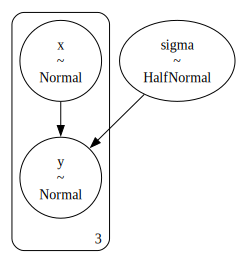

In [82]:
pm.model_to_graphviz(pmodel)

上の例では、各ボックス (またはプレート) の左下の数字は、その中の分布の次元を示しています。 分布が数値のあるボックスの外側にある場合、その分布はスカラー形状になります。

このツールを使用して、暗黙的および明示的なディメンションを確認してみましょう:

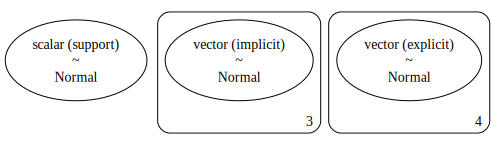

In [83]:
with pm.Model() as pmodel:
    pm.Normal("scalar (support)")
    pm.Normal("vector (implicit)", mu = [1, 2, 3])
    pm.Normal("vector (explicit)", shape = (4,))

pm.model_to_graphviz(pmodel)

## Dims
PyMC は ```dims``` の概念をサポートしています。 多くの確率変数があると、どの次元がどの「現実世界」のアイデアに対応するかが混乱する可能性があります。 観測値の数、処理される単位の数など。 ``dims`` 引数は、この意味を伝えることができる人間が判読できる追加のラベルです。 単独で使用する場合、```dims``` を明示的な ```shape``` 情報と組み合わせる必要があります。

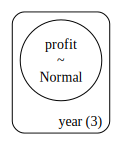

In [84]:
with pm.Model() as model:
    pm.Normal("profit", shape = (3,), dims = "year")

pm.model_to_graphviz(model)

```dims``` がますます強力になるのは、モデル自体で指定された ```coords``` を使用する場合です。 これにより、各 ```dim``` エントリに一意のラベルが付けられ、より意味のあるものになります。

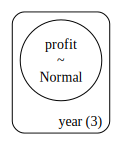

In [85]:
coords = {"year": [2020, 2021, 2022]}
with pm.Model(coords = coords) as model:
    pm.Normal("profit", dims = "year")

pm.model_to_graphviz(model)

この場合、分布の次元は実際に使用される ```dims``` によって定義できます。 形状を渡したり、暗黙的にバッチ化されたディメンションを定義したりする必要はありませんでした。

多変量正規の例を使用して、さまざまな次元のフレーバーを確認してみましょう。

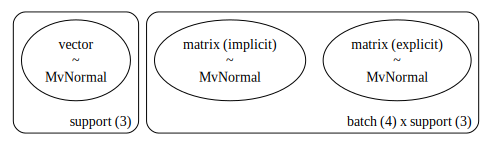

In [86]:
coords = {
    "batch": [0, 1, 2, 3],
    "support": ["A", "B", "C"],
}
with pm.Model(coords = coords) as model:
    pm.MvNormal("vector", mu = [0, 0, 0], cov = np.eye(3), dims = ("support",))
    pm.MvNormal("matrix (implicit)", mu = np.zeros((4, 3)), cov = np.eye(3), dims = ("batch", "support"))
    pm.MvNormal(
        "matrix (explicit)", mu = [0, 0, 0], cov = np.eye(3), shape = (4, 3), dims = ("batch", "support")
    )

pm.model_to_graphviz(model)


````
```Tip
最終的なモデルの公開では、ラベルが ```arviz.InferenceData``` に渡されるため、dim と coords を推奨します。 これは、透明性と他の人にとっての読みやすさの両方を実現するベスト プラクティスです。 また、単一の開発者のワークフローにも役立ちます。たとえば、3 次元以上の分布がある場合、どの次元がどのモデルの概念に対応するかを示すのに役立ちます。
```
````

## Tips for debugging shape issues
これらすべてのツールは利便性のために提供されており、PyMC はユーザーの意図を理解するために最善を尽くしていますが、混合次元ツールの結果が必ずしも意図した最終次元になるとは限りません。 場合によっては、モデルがサンプリングするまでエラーを示さない場合や、問題をまったく示さない場合があります。 次元を扱う場合、特により複雑なものを推奨します:

* ``model_to_graphviz`` を使用してサンプリング前にモデルを視覚化する
* ```draw``` または ```sample_prior detective``` を使用してエラーを早期に検出する
* 返された ```az.InferenceData``` オブジェクトを検査して、すべての配列サイズが意図したとおりであることを確認します
* エラーを追跡するときに素数を使用して形状を定義します。

In [87]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Apr 02 2024

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

pytensor: 2.19.0

pymc    : 5.12.0
pytensor: 2.19.0
numpy   : 1.26.4

Watermark: 2.4.3

